## Part 1.2 

In [258]:
#Here we are preprocessing all the anat and func data. 
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ,get_json_from_file

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob
from scipy.ndimage import zoom
import shutil


import ants
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json

from IPython.display import display, HTML


In [259]:
%gui wx

In [260]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

In [261]:
#import useful paths : 

fmri_path = os.path.join('dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concat.nii.gz')
events_path = os.path.join('dataset/ds000171/sub-control01/func/sub-control01_task-music_concat_run_events.tsv')
fmri_img = nib.load(fmri_path)
events = pd.read_csv(events_path, sep='\t')  

print(os.path.abspath(fmri_path))

/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concat.nii.gz


In [262]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(fmri_path)




(ipykernel_launcher.py:7209): Gdk-WARNING **: 16:25:09.180: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [263]:
events

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [ ]:
#get TR

TR = fmri_img.header.get_zooms()[3]
print(TR)

In [294]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.image import load_img
import pandas as pd


# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=int(TR),
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, events)

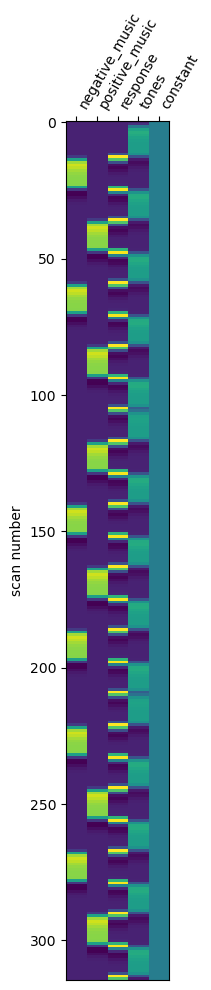

Regressor names: ['negative_music', 'positive_music', 'response', 'tones', 'constant']


In [295]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

# Get regressor names from the design matrix
regressor_names = fmri_glm.design_matrices_[0].columns.tolist()
print("Regressor names:", regressor_names)

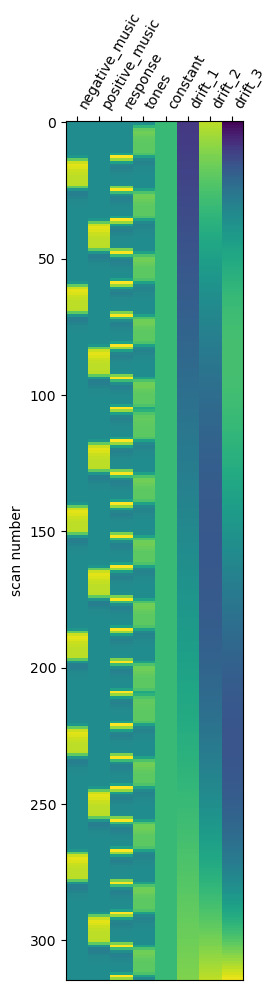

In [314]:
# Creation of the drift model:
from nilearn.glm.first_level.design_matrix import _make_drift

column_values, column_names = _make_drift(drift_model='polynomial', frame_times=np.asarray(list(range(0, 945, 3))), order=3, high_pass=None)

design_mat = fmri_glm.design_matrices_[0]
for (col, name) in zip(column_values.T, column_names):
    design_mat[name] = col

plot_design_matrix(design_mat)
plt.show()

In [318]:
fit_glm = FirstLevelModel(t_r=int(TR),
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='polynomial',
                           drift_order=3,
                           high_pass=.01)




fit_glm.fit(fmri_img, design_matrices=[design_mat])

FirstLevelModel(drift_model='polynomial', drift_order=3, hrf_model='spm', t_r=3)

In [319]:
# Create the dictionary of the conditions

conditions = {
    'negative': np.array([1, 0, 0, 0, 0, 0, 0, 0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract active
    'positive':np.array([0, 1, 0, 0, 0, 0, 0, 0]),
    'response':np.array([0, 0, 1, 0, 0, 0, 0, 0]),
    'tones':np.array([0, 0, 0, 1, 0, 0, 0, 0]),
    'constant':np.array([0, 0, 0, 0, 1, 0, 0, 0]),
    'drift1':np.array([0, 0, 0, 0, 0, 1, 0, 0]),
    'drift2':np.array([0, 0, 0, 0, 0, 0, 1, 0]),
    'drift3':np.array([0, 0, 0, 0, 0, 0, 0, 1])# Specify the np array, e.g. np.array([2, -1, 0]) to extract rest
}

positive_minus_negative = conditions['positive']-conditions['negative']

BETA MAP FOR negative


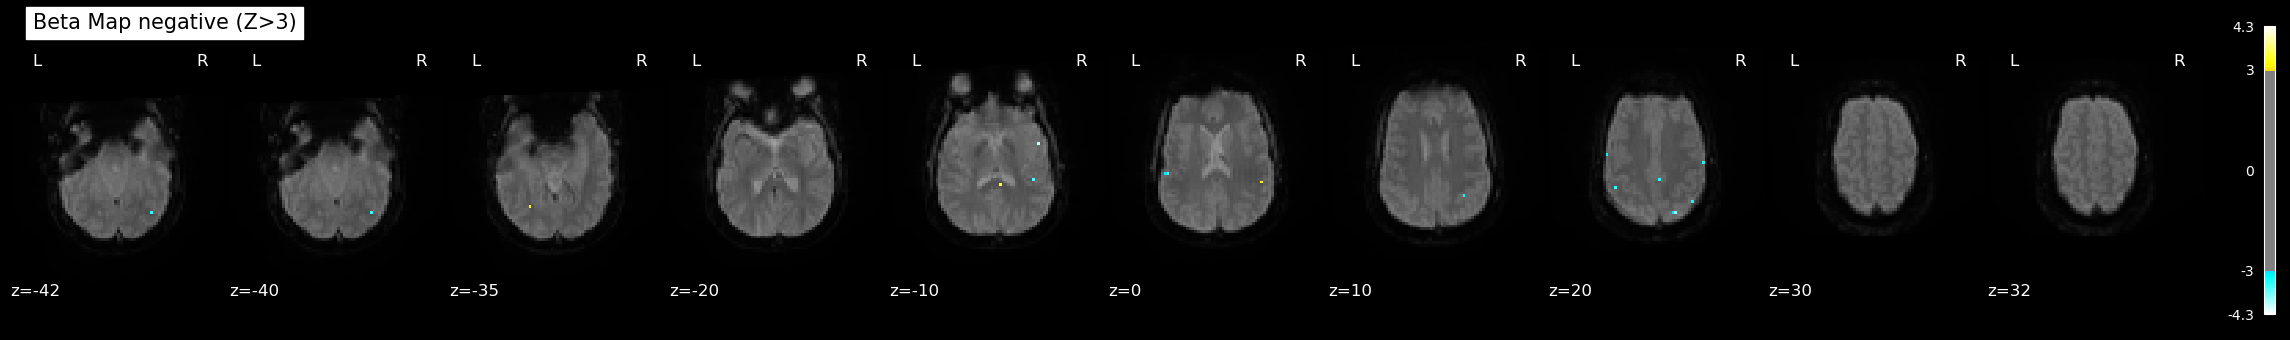

BETA MAP FOR positive


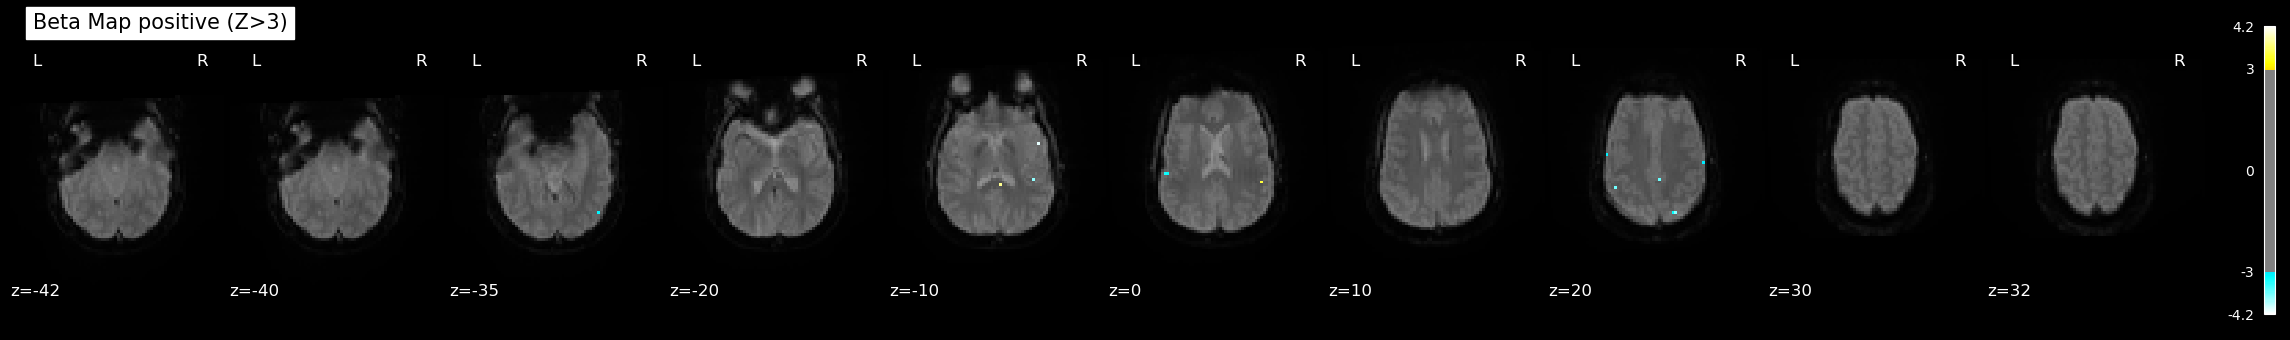

BETA MAP FOR response


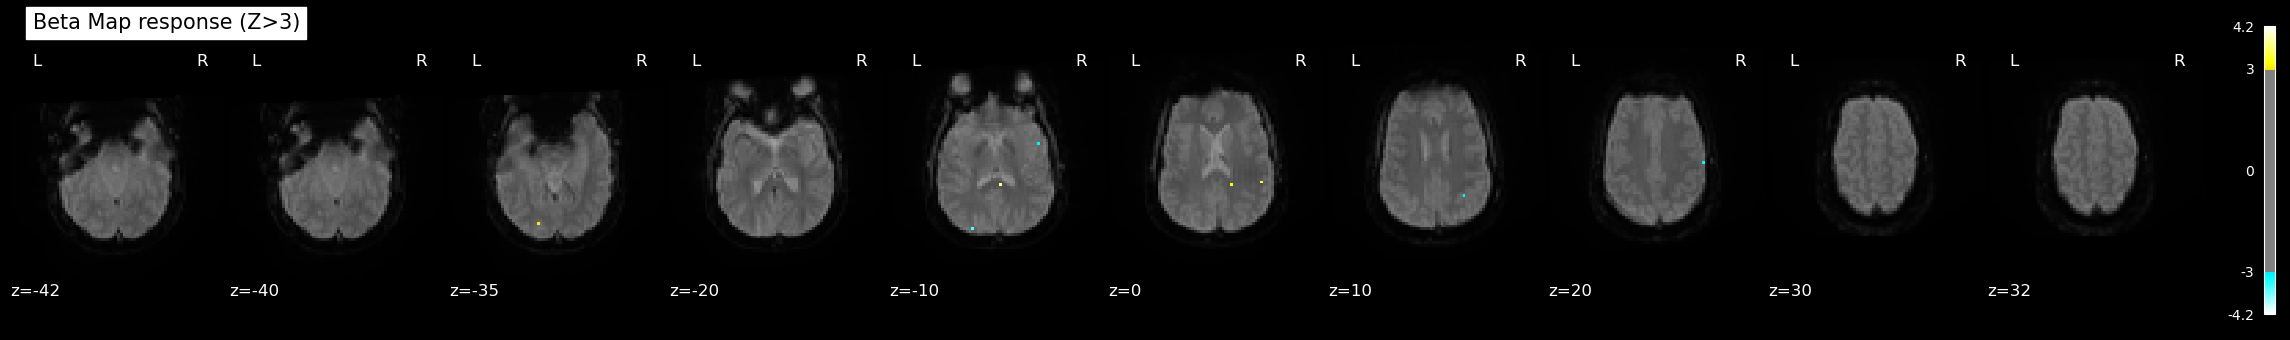

BETA MAP FOR tones


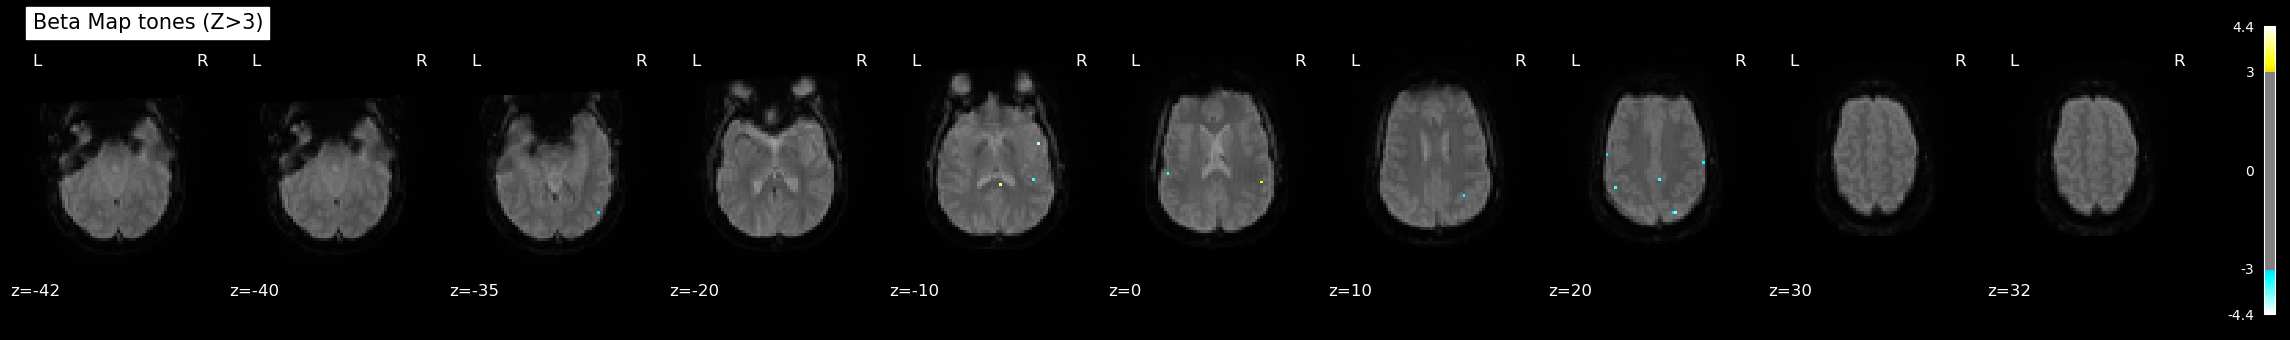

BETA MAP FOR constant


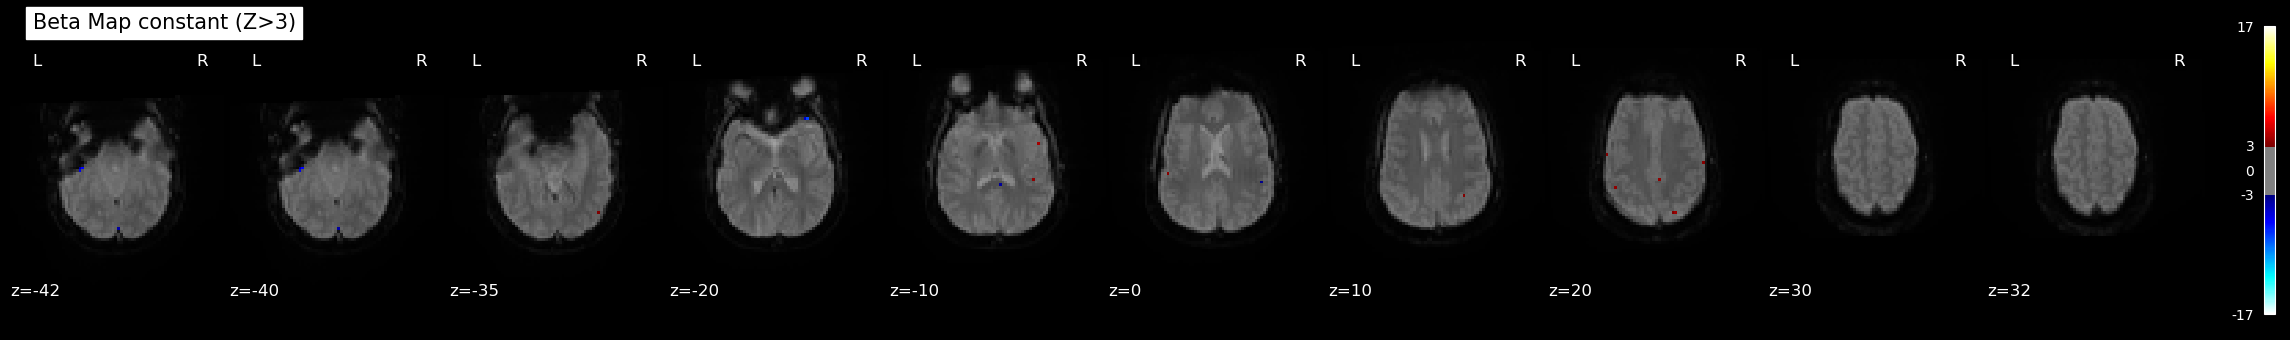

BETA MAP FOR drift1


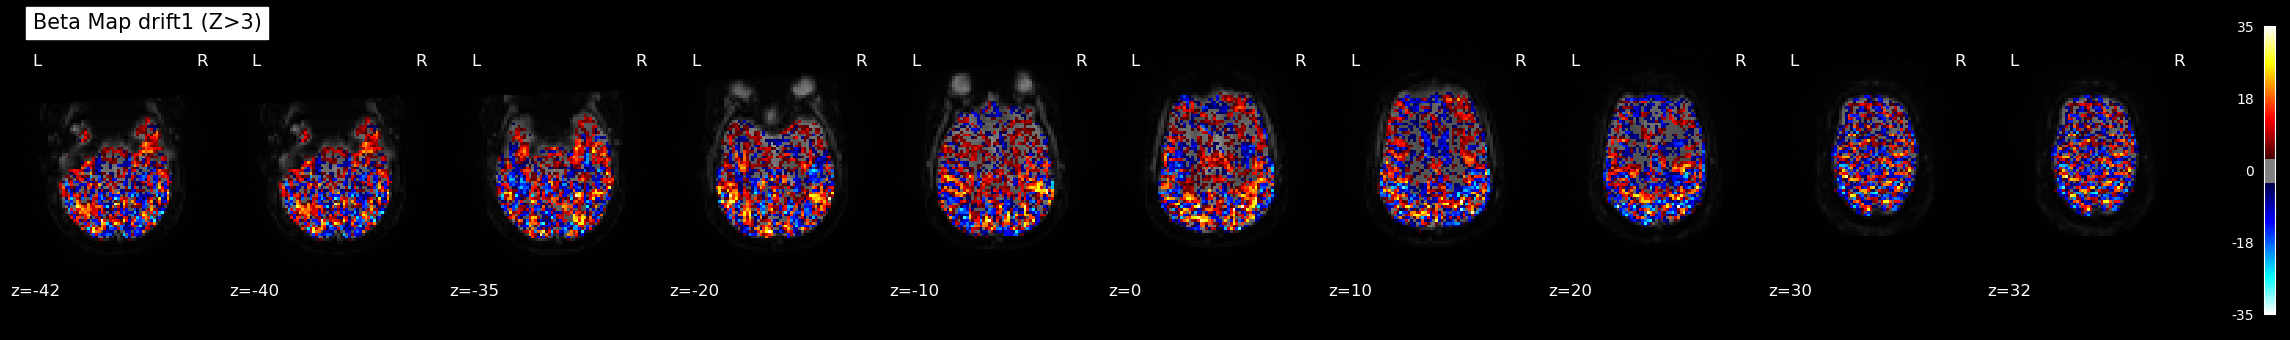

BETA MAP FOR drift2


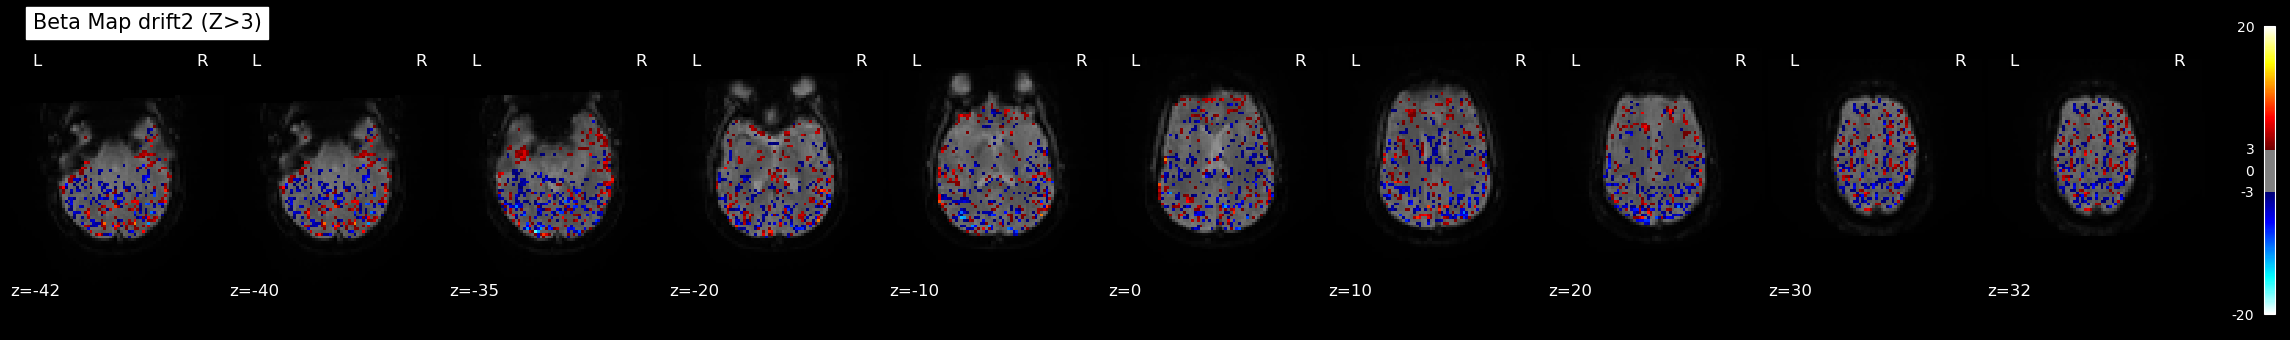

BETA MAP FOR drift3


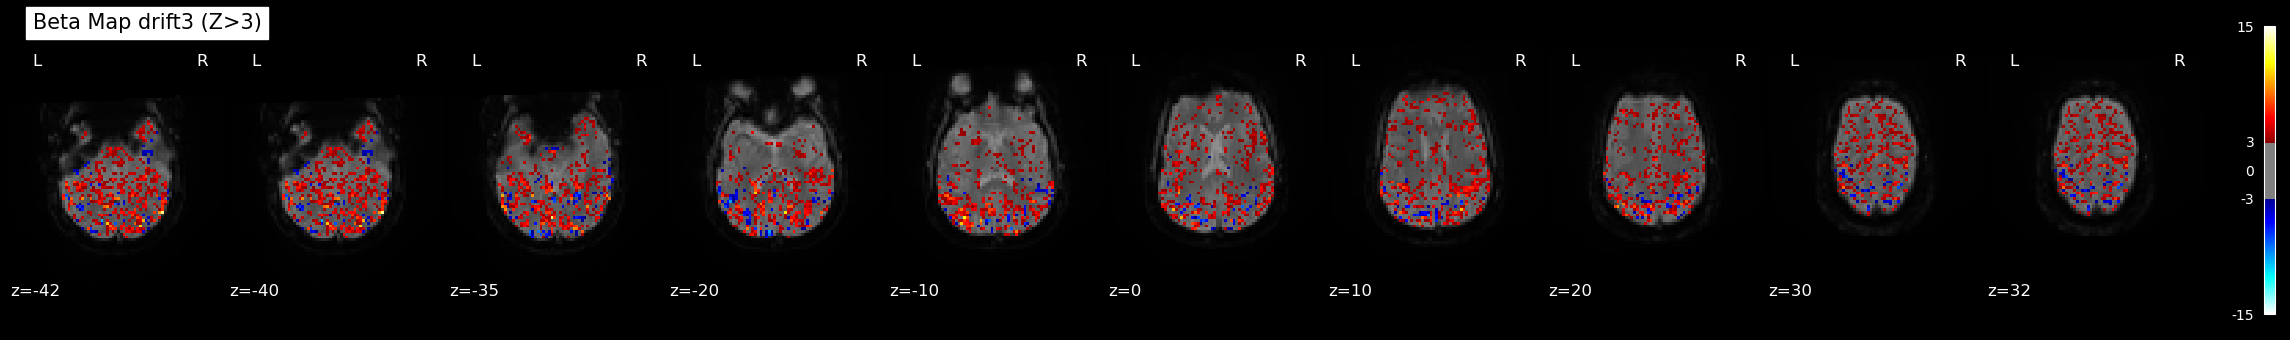

In [323]:
for condition in conditions :
    regressor=conditions[condition]
    print(f'BETA MAP FOR {condition}')
    #plot_contrast_matrix(regressor, design_matrix=design_mat) 
    z_map = fit_glm.compute_contrast(regressor,
                                  output_type='z_score')

    nib.save(z_map, 'z_map_uncorrected.nii.gz')
    mean_img_ = mean_img(fmri_img),
    plot_stat_map(z_map, bg_img=mean_img_[0], threshold=3,
              display_mode='z', cut_coords=[-42, -40, -35, -20, -10, 0, 10, 20, 30, 32], black_bg=True,
              title=f'Beta Map {condition} (Z>3)')
    plt.show()


<Axes: label='conditions'>

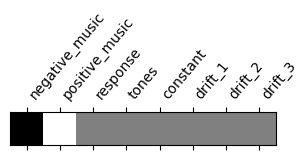

In [324]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(positive_minus_negative, design_matrix=design_mat)  ####TODO ADD COLOR SCALE

In [325]:
import nibabel as nib
z_map = fit_glm.compute_contrast(positive_minus_negative,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

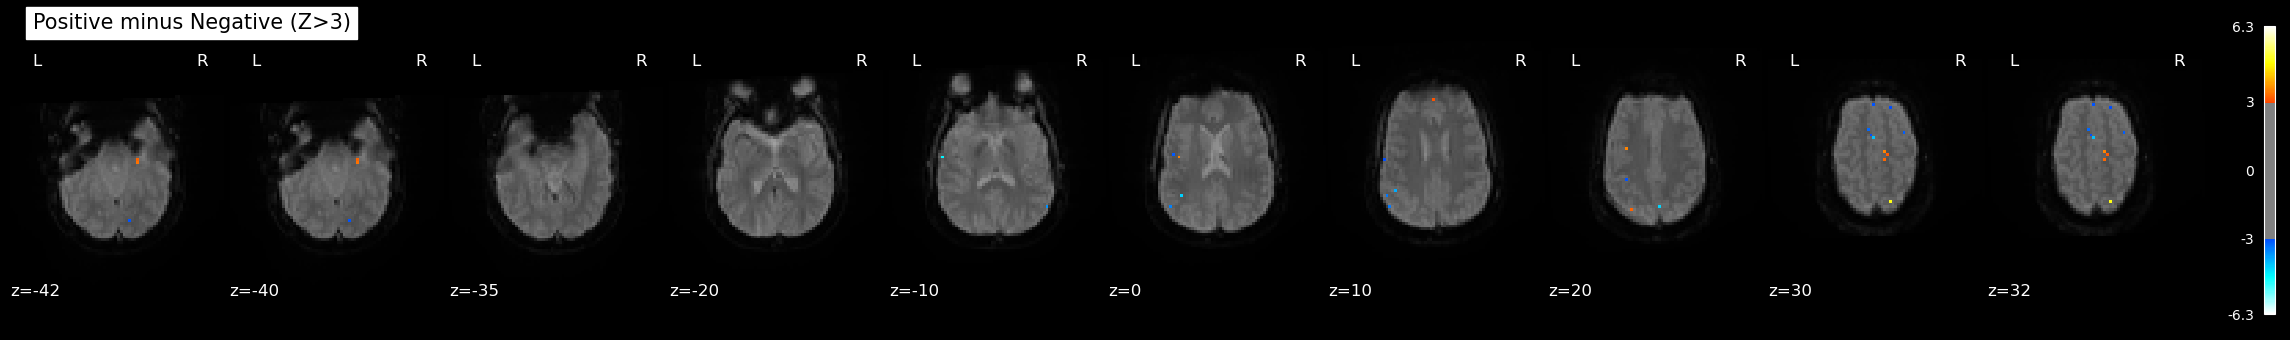

In [326]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=3,
              display_mode='z', cut_coords=[-42, -40, -35, -20, -10, 0, 10, 20, 30, 32], black_bg=True,
              title='Positive minus Negative (Z>3)')
plt.show()

In [ ]:
from nilearn.glm import threshold_stats_img

#Link to threshold_stats_img function documentation
#https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html

cluster_size = 10 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.05 # Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
print(threshold)
# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-45, -40, -35, -20, -10, 0, 10, 20, 30, 32], black_bg=True,
              title='Active minus Rest (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()